Data Collection and Preprocessing

In [170]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [171]:
# Load Dataset
zomato_df = pd.read_csv("zomato.csv", encoding='utf-8', encoding_errors='ignore')
print("Dataset Loaded. Shape:", zomato_df.shape)

Dataset Loaded. Shape: (51717, 17)


In [172]:
# Fix encoding issues in restaurant names using bytes decoding fallback
def fix_garbled(text):
    try:
        return text.encode('raw_unicode_escape').decode('utf-8')
    except:
        return text

zomato_df['name'] = zomato_df['name'].apply(lambda x: fix_garbled(x) if isinstance(x, str) else x)

In [173]:
# Manual fix for known garbled restaurant names
zomato_df['name'] = zomato_df['name'].replace({
    'CafÃÂÃÂÃÂÃÂ© Down The Alley': 'Café Down The Alley',
    'CafÃÂÃÂÃÂÃÂ© Felix': 'Café Felix',
    'CafÃÂÃÂÃÂÃÂ© Mor\'ish': 'Café Mor\'ish',
    'Moto Store & CafÃÂÃÂÃÂÃÂ©': 'Moto Store & Café',
    'Urban Solace - CafÃÂÃÂÃÂÃÂ© for the Soul': 'Urban Solace - Café for the Soul',
    'WAFL CafÃÂÃÂÃÂÃÂ©': 'WAFL Café',
    'Cafe Shuffle': 'Café Shuffle',
    'Penthouse Cafe': 'Penthouse Café'
})


In [174]:
# View Initial Data
print(zomato_df.head(3))
print(zomato_df.columns)

                                                 url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   

                                             address             name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...            Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...   Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...  San Churro Cafe   

  online_order book_table   rate  votes                           phone  \
0          Yes        Yes  4.1/5    775  080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                    080 41714161   
2          Yes         No  3.8/5    918                  +91 9663487993   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   

                    

In [175]:
# Drop Unnecessary Columns
columns_to_drop = ['url', 'address', 'phone', 'menu_item', 'reviews_list']
zomato_df.drop(columns=columns_to_drop, inplace=True)

In [176]:
# Remove Duplicates
zomato_df.drop_duplicates(inplace=True)

In [177]:
# Handle Missing Values
zomato_df.dropna(subset=['rate', 'cuisines', 'dish_liked'], inplace=True)

In [178]:
# Fill NaNs in important text columns to avoid issues in TF-IDF
for col in ['name', 'cuisines', 'dish_liked', 'rest_type']:
    zomato_df[col].fillna('', inplace=True)

In [179]:
# Clean 'rate' column (e.g., '4.1/5' to 4.1)
zomato_df['rate'] = zomato_df['rate'].apply(lambda x: str(x).split('/')[0]).replace('NEW', np.nan)
zomato_df['rate'] = pd.to_numeric(zomato_df['rate'], errors='coerce')

In [180]:
# Create rating bucket
zomato_df['rating_bucket'] = pd.cut(zomato_df['rate'],
                                    bins=[0, 3.0, 4.0, 5.0],
                                    labels=['Low', 'Average', 'High'])


In [181]:
# Clean 'approx_cost(for two people)' column
zomato_df['approx_cost(for two people)'] = zomato_df['approx_cost(for two people)'].str.replace(',', '')
zomato_df['approx_cost(for two people)'] = pd.to_numeric(zomato_df['approx_cost(for two people)'], errors='coerce')

In [182]:
# Rename Columns
zomato_df.rename(columns={
    'approx_cost(for two people)': 'cost',
    'listed_in(type)': 'type',
    'listed_in(city)': 'city'
}, inplace=True)

In [183]:
# Create price category after renaming
zomato_df['price_range'] = pd.cut(zomato_df['cost'],
                                  bins=[0, 500, 1000, 2000, np.inf],
                                  labels=['Budget', 'Moderate', 'Expensive', 'Luxury'])


In [184]:
# Reset Index
zomato_df.reset_index(drop=True, inplace=True)

In [185]:
# Final Cleaned Dataset
print("Cleaned Dataset Shape:", zomato_df.shape)
print(zomato_df.dtypes)

Cleaned Dataset Shape: (23565, 14)
name               object
online_order       object
book_table         object
rate              float64
votes               int64
location           object
rest_type          object
dish_liked         object
cuisines           object
cost              float64
type               object
city               object
rating_bucket    category
price_range      category
dtype: object


In [186]:
# Create combined_features column for model
zomato_df['combined_features'] = (
    zomato_df['name'] + ' ' +
    zomato_df['cuisines'] + ' ' +
    zomato_df['dish_liked'] + ' ' +
    zomato_df['rest_type']
)

In [187]:
# Save Cleaned Data
zomato_df['rate'] = zomato_df['rate'].round(1)
zomato_df['cost'] = zomato_df['cost'].fillna(0).astype(int)
zomato_df.to_csv("restaurant1.csv", index=False)
print("Cleaned data saved as restaurant1.csv")

Cleaned data saved as restaurant1.csv


In [188]:
# Save corrected data
zomato_df.to_csv("restaurant1_cleaned.csv", index=False)

Data Visualization

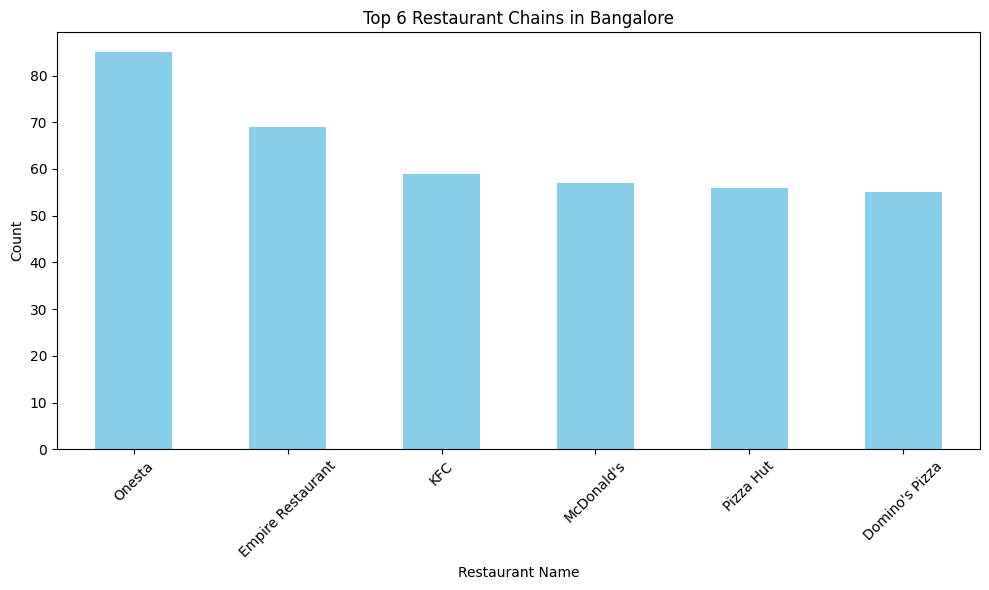

In [189]:
# Top 6 Most Frequent Restaurants
plt.figure(figsize=(10,6))
zomato_df['name'].value_counts().head(6).plot(kind='bar', color='skyblue')
plt.title('Top 6 Restaurant Chains in Bangalore')
plt.xlabel('Restaurant Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

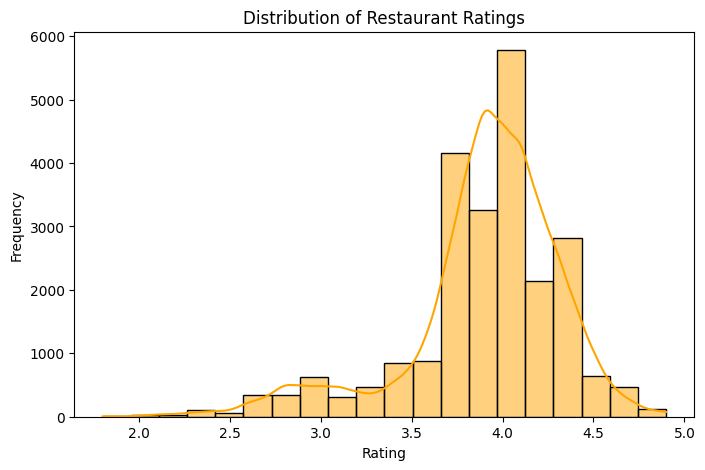

In [190]:
# Rating Distribution
plt.figure(figsize=(8,5))
sns.histplot(zomato_df['rate'].dropna(), kde=True, bins=20, color='orange')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

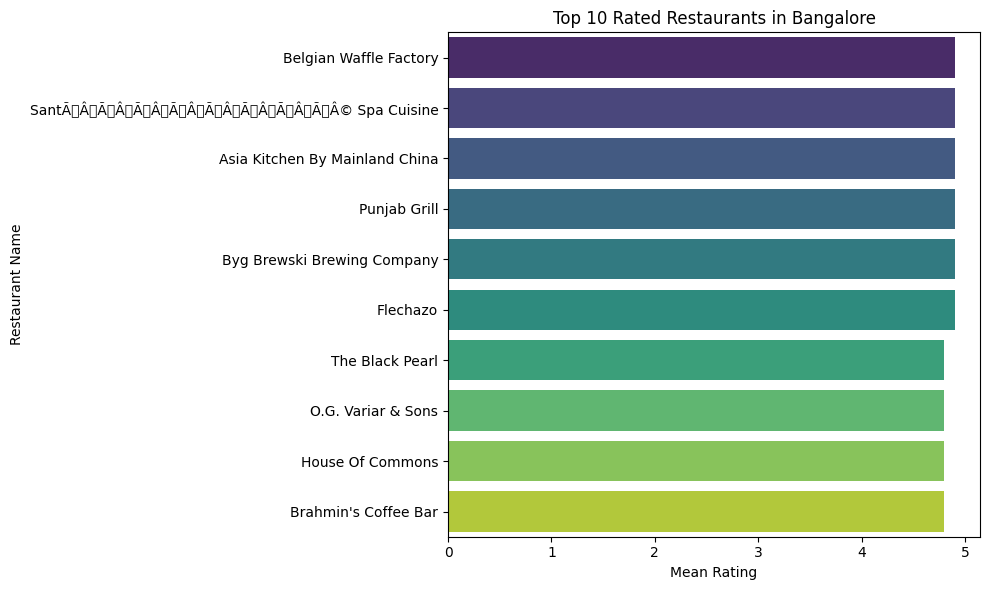

In [191]:
# Top 10 Rated Restaurants
top_rated = zomato_df.drop_duplicates(subset='name')
top_10 = top_rated.sort_values(by='rate', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=top_10, x='rate', y='name', palette='viridis')
plt.title('Top 10 Rated Restaurants in Bangalore')
plt.xlabel('Mean Rating')
plt.ylabel('Restaurant Name')
plt.tight_layout()
plt.show()

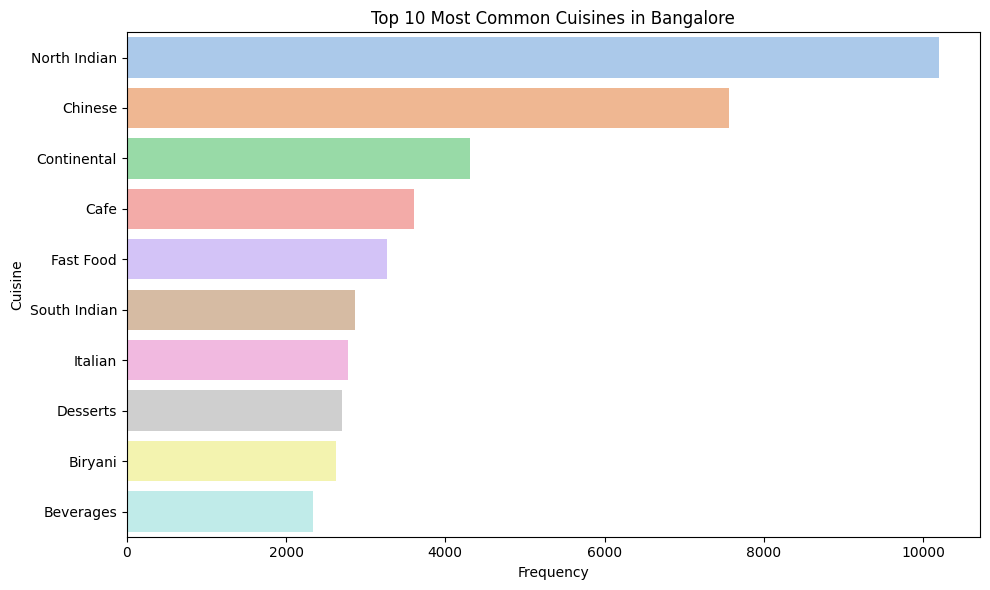

In [192]:
# Top Cuisine Frequencies
from collections import Counter
cuisine_series = zomato_df['cuisines'].dropna().apply(lambda x: x.split(', '))
cuisine_flat = [item for sublist in cuisine_series for item in sublist]
cuisine_counts = Counter(cuisine_flat)
top_cuisines = pd.DataFrame(cuisine_counts.most_common(10), columns=['Cuisine', 'Count'])

plt.figure(figsize=(10,6))
sns.barplot(data=top_cuisines, x='Count', y='Cuisine', palette='pastel')
plt.title('Top 10 Most Common Cuisines in Bangalore')
plt.xlabel('Frequency')
plt.ylabel('Cuisine')
plt.tight_layout()
plt.show()